# Summary

## Files

My project includes the following files:

* **model.py** contains functions to build various models. I ended up using the [Nvidia architecture](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

* **drive.py** is the script to drive the car in autonomous mode

* **model.h5** contains a trained CNN using the Nvidia architecture, 0 dropout, and 0 regularization

* **video.mp4** contains a video of the trained agent driving around the course

In addition, I've included other utility files I used to load data, train the network, and sync code.

* **load_data.py** contains code to load and augment data

* **train.py** is the script to actually get data and train multiple models with various parameters.

* **sync.sh** is a short script to sync code to the remote server

* **drive.sh** is a short script to download a named model and run the server for autonomous mode.

## Driving

This model can be used to drive the car autonomously in the simulator by running

`python drive.py model.h5`

# Final Model 

## Architecture 

The model uses the [Nvidia architecture](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) with a normalizing layer and a cropping layer added at the beginning. The top 70px and the bottom 20px of the camera image are cut off in the cropping layer to reduce noise.

The cropping layer is then followed by 3 convolution layers with 5x5 filters, 2x2 strides and depths between 24 and 48. These are followed 2 more non-strided convolution layers with 3x3 filters at 64 depth.

The convolution layers are then flattened and followed by 3 fully connected layers with 100, 50, and 10 neurons respectively. These are then connected to the output layer.

![Nvidia Architecture](images/nvidia-arch.png)

## Parameters

After experimentation, I found that the above model is best trained for **3 epochs** with **no dropout or regularization**.

Dropout and regularization tended to cause the model to underfit, requiring more epochs to achieve a similar performance. And adding more epochs without regularization caused the model to overfit, displaying lower validation errors but failing to stay on the road in the simulator.

The model used an Adam optimizer, so we did not need to manually tune learning rate.

# Experiments

I experimented a lot for this project, switching between changing models, modifying hyperparameters, and trying more data augmentation iteratively to get to the final architecture.

### Data prep

I started off training by using `train_test_split` to hold 20% of the data for validation. I used a default `epoch` of 5.

### Single Layer Network

The first model I tried was a simple 1 layer neural network. This model was used mainly to get the workflow up and running, and failed as expected. The car ran off the road almost immediately.

### LeNet

The next model I tried was LeNet. The first run was promising, as the car started to move forward. However, the driving angle was very obviously biased to the left.

### Data Augmentation - Normalizing, Flipping Images

This was when I first started augmenting the data. I added a layer to normalize the input, then added code to flip every image to counteract the counter-clockwise bias (see below)

The resulting model is better, but falls into the water at the first sharp left turn.

It's also at this point that I start seeing validation losses go up, possibly because we have more data after adding the flipped images. I lower default `epoch` down to 3.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


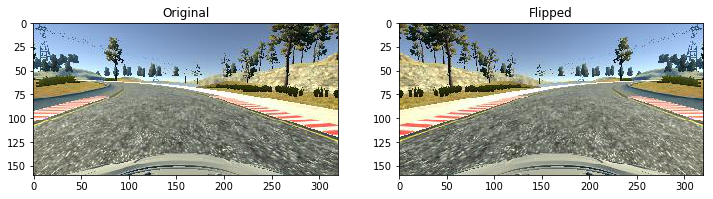

In [6]:
%load_ext autoreload
%autoreload 2

from matplotlib import image as mpimg
from matplotlib import pyplot as plt

from load_data import flip_data

%matplotlib inline

# Flip image

orig_img = mpimg.imread('images/original.jpg')
flipped_img, _ = flip_data(orig_img, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.imshow(orig_img)
ax1.set_title('Original')

ax2.imshow(flipped_img)
ax2.set_title('Flipped')

### Data Augmentation - Cropping Images

I also try cropping the image here to see if the model can perform better. Looking at the images above, we can see that the top 70px and the bottom 20px introduce a lot of noise that don't necessarily help the model decide what angle to turn the steering wheel.

Below is code to show what the image looks like after it's been cropped, but this is implemented as a `Lambda` layer in the code.

(160, 320, 3)


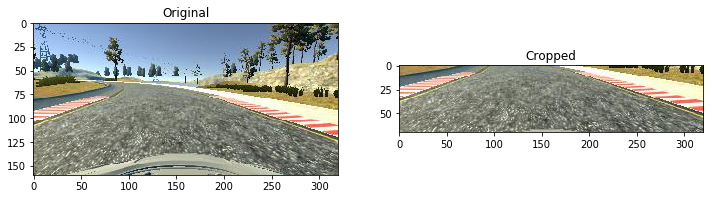

In [12]:
import numpy as np

cropped_img = np.copy(orig_img)
img_shape = cropped_img.shape
print(img_shape)

cropped_img = cropped_img[70:(img_shape[0] - 20), :, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.imshow(orig_img)
ax1.set_title('Original')

ax2.imshow(cropped_img)
ax2.set_title('Cropped')

The model gets all the way to the bridge at this point, but is unable to get back on the road after. It typically gets stuck on the bridge, or goes off road once it gets off.

### Nvidia

I decided to try the same Nvidia network here to see if it can get past the bridge. At the current data size, it seemed Nvidia model overfit quite easily, even at `epoch=3`. Validation error starting going up again, and the model actually performed worse than LeNet on the track.

### Data Augmentation - Reverse Track, Recovery Data

At this point I realize I need more data.

The first thing I tried to do was to drive the track in reverse. The premise here was to help the model generalize better, and to prevent it from memorizing the track.

The second thing I tried to was add a lap of recovery data. This seemed necessary especially at the bridge, where the model didn't know what to do if it veered too close to the edges. This was likely because the lanes in most of the training data was either yellow or red/white stripes. The model also seemed to have a hard time staying on the road when there are gaps of dirt in the lanes (ex: right after the bridge), so I added more data to help it recover when it gets too close to the edge in those situations.

### Data Processing - Generators

I start running into memory issues here, and implement a generator to load training data when it's needed, rather than trying to fit the entire set into memory at once.

### Dropout, L2 Regularization

To counteract overfitting, I also start experimenting with both dropout and with L2 weight regularization at fully connected layers of both LeNet and Nvidia models.

### Found Solution!

To find an optimal solution, I ended up training 24 models overnight. These 24 models were made of unique combinations of model type (Lenet, Nvidia), dropout (`0.0`, `0.25`, `0.5`), L2 regularization beta (`0.0`, `5e-4`), and epoch (3, 5).

Out of these, I found that the **Nvidia** model with **0 dropout**, **0 L2 reg_beta** performed best training at **3 epochs**.

Nvidia generally outperformed LeNet, but tended to overfit at higher epochs. I wasn't ever able to get LeNet to go past the dirt opening after the bridge. Ultimately, the Nvidia model trained with 3 epochs of data and no regularization was able to all the way around the track, while the same model trained on 5 epochs found places to get stuck regardless of how much regularization I added.

# Simulation

Below is a video of the final trained model driving around the track

In [16]:
from IPython.display import HTML

HTML("""
<video width="640" height="320" controls>
    <source src="{0}">
</video>
""".format('video.mp4'))